# Make logoplots showing key sites of escape

In [41]:
import functools
import itertools
import operator
import os
import requests
import tarfile


import altair as alt

import dmslogo
import dmslogo.colorschemes

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd
import yaml

_ = alt.data_transformers.disable_max_rows()
plt.rcParams['svg.fonttype'] = 'none'

In [42]:
min_entry = -3
min_ACE2 = -3
n_sites_to_show = 10

In [43]:
# per_antibody_escape = pd.read_csv("../results/summaries/antibody_escape.csv")
per_antibody_escape = pd.read_csv(snakemake.input.per_antibody_escape)

In [44]:
per_antibody_escape = per_antibody_escape.dropna()

filtered_df = per_antibody_escape[
    (per_antibody_escape['spike mediated entry'] >= min_entry) &
    (per_antibody_escape['ACE2 binding'] >= min_ACE2)
]

/tmp/ipykernel_53945/2022575420.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["color"] = (


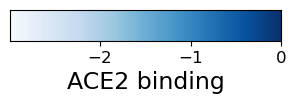

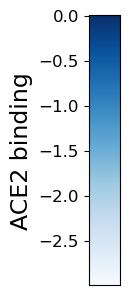

In [46]:
# for coloring by ACE2 binding
ace2_colormap = dmslogo.colorschemes.ValueToColorMap(
    minvalue=max(-4, filtered_df["ACE2 binding"].min()),
    maxvalue=0,
    cmap="Blues",
)

filtered_df["color"] = (
    filtered_df["ACE2 binding"]
    .clip(lower=ace2_colormap.minvalue, upper=ace2_colormap.maxvalue)
    .map(ace2_colormap.val_to_color)
)

for orientation in ["horizontal", "vertical"]:
    fig, _ = ace2_colormap.scale_bar(
        orientation=orientation, label="ACE2 binding",
    )
    svg = os.path.join("results/escape_logos",f"key_escape_sites_ace2_scalebar_{orientation}.svg")
    print(f"Saving to {svg}")
    fig.savefig(svg, bbox_inches="tight")
    plt.close(fig)

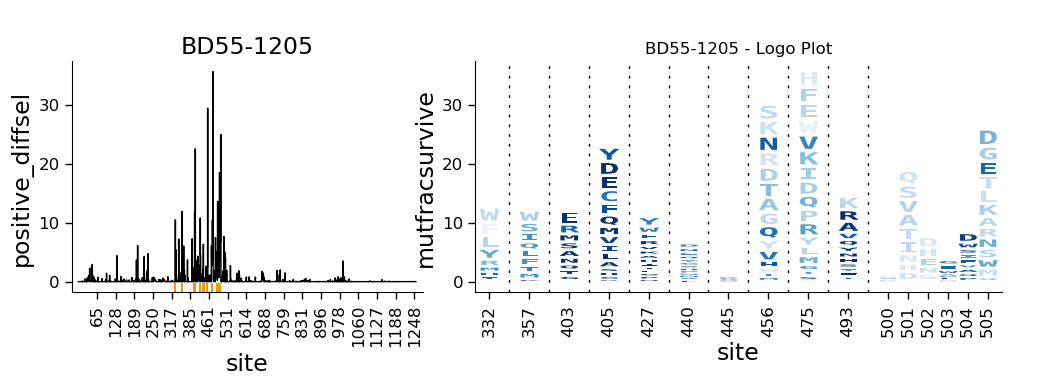

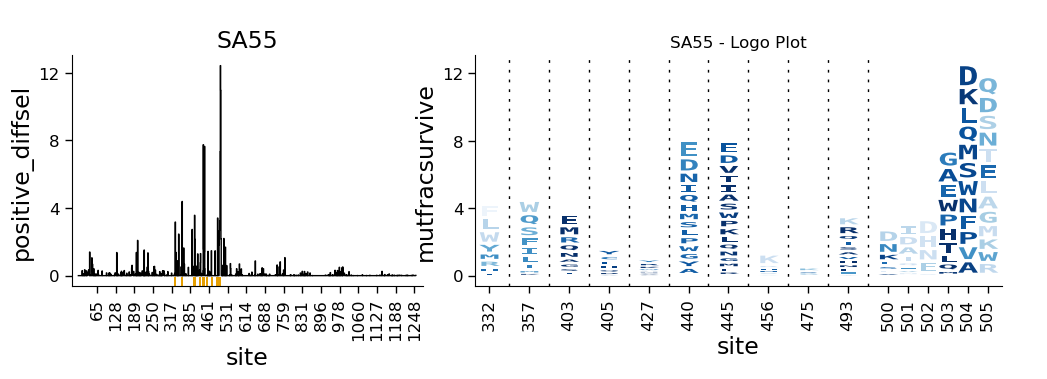

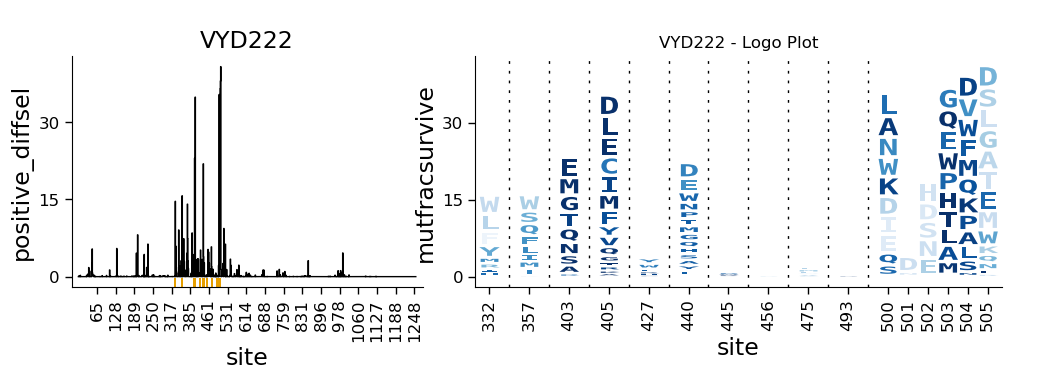

In [47]:
# Ensure 'site' is numeric 
filtered_df = filtered_df[filtered_df['site'].apply(lambda x: str(x).isdigit())].copy()
filtered_df['site'] = filtered_df['site'].astype(int)

# Melt to long format
antibody_cols = ['BD55-1205', 'SA55', 'VYD222']
long_df = filtered_df.melt(
    id_vars=['site', 'wildtype', 'mutant', 'color'],
    value_vars=antibody_cols,
    var_name='antibody',
    value_name='mutfracsurvive'
)

long_df = long_df.rename(columns={'mutant': 'mutation'})

# Compute site total escape
long_df['totfracsurvive'] = long_df.groupby(['antibody', 'site'])['mutfracsurvive'].transform('sum')

# Step 4: Add positive_diffsel
long_df['positive_diffsel'] = long_df['totfracsurvive'].clip(lower=0)

# Mark top 10 sites per antibody 
# Initialize show_site column
long_df['show_site'] = False

# Store all top 10 sites for each antibody
all_top_sites = set()

# First: mark top 10 per antibody and collect global top sites
for ab in antibody_cols:
    top_sites = (
        long_df[long_df['antibody'] == ab]
        .groupby('site')['totfracsurvive']
        .mean()
        .nlargest(10)
        .index
    )
    all_top_sites.update(top_sites)
    long_df.loc[(long_df['antibody'] == ab) & (long_df['site'].isin(top_sites)), 'show_site'] = True

# Second: also mark True if site is among the top 10 for any antibody
long_df.loc[long_df['site'].isin(all_top_sites), 'show_site'] = True


# Plot per antibody 
for ab in antibody_cols:
    df_ab = long_df.query('antibody == @ab').copy()

    # Map site to sequential integers for x_col
    unique_sites = sorted(df_ab['site'].unique())
    site_map = {s: i+1 for i, s in enumerate(unique_sites)}
    df_ab['isite'] = df_ab['site'].map(site_map)

    # Create figure
    fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 1.5]})
    fig.subplots_adjust(wspace=0.12)
    fig.set_size_inches(12, 3)

    # Line plot (left) using positive_diffsel
    dmslogo.draw_line(
        df_ab,
        x_col="isite",
        height_col="positive_diffsel",
        xtick_col="site",
        show_col="show_site",
        ax=axes[0],
        title=f"{ab}"
    )

    # Logo plot (right) for top 10 sites
    dmslogo.draw_logo(
        df_ab.query("show_site"),
        x_col="isite",
        letter_col="mutation",
        letter_height_col="mutfracsurvive",
        clip_negative_heights=True,
        color_col="color",
        ax=axes[1],
        xtick_col="site",
    )
    axes[1].set_title(f"{ab} - Logo Plot")

    plt.show()

    # save svg
    svg_path = os.path.join("results/escape_logos",f"{ab}_spike_DMS_line_logo_plot.svg")
    fig.savefig(svg_path, format="svg", bbox_inches="tight")
    print(f"Saved {svg_path}")

    plt.close(fig)

## Plot logoplots for Cao data

In [49]:
# URL for TAR file
tar_url = "https://zenodo.org/records/13893217/files/data_scripts_plots.tar.gz"
local_tar = "results/escape_logos/data_scripts_plots.tar.gz"

# get the TAR file if it doesn't already exist
if not os.path.isfile(local_tar):
    print(f"Getting {tar_url=} to {local_tar=}")
    # Stream and save the file
    with requests.get(tar_url, stream=True) as response:
        response.raise_for_status()  # Ensure the request was successful
        with open(local_tar, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):  # Write in chunks
                file.write(chunk)
else:
    print(f"{local_tar=} already downloaded")

local_tar='data_scripts_plots.tar.gz' already downloaded


In [38]:
target_file = "./data/DMS/antibody/dms_antibodies_XBB15_JN1_agg.csv"  # file w DMS data

# Open the TAR file and list its contents
with tarfile.open(local_tar, "r") as tar:
    file_names = tar.getnames()  # Get list of file names in the TAR archive
    # print(f"\nContents of {local_tar=}:\n\t" + "\n\t".join(file_names))
    assert target_file in file_names, f"{target_file=} not in {local_tar=}"
    print(f"Reading {target_file=} from {local_tar=}")
    f = tar.extractfile(target_file)
    df = pd.read_csv(f)

df['antibody'] = df['antibody'].replace('BD55-5514', 'SA55')

Reading target_file='./data/DMS/antibody/dms_antibodies_XBB15_JN1_agg.csv' from local_tar='data_scripts_plots.tar.gz'


,site,wildtype,mutation,mut_escape,antibody,antigen
0,331,N,C,0.051094,GC1597,XBB.1.5_RBD
1,331,N,E,0.004040,GC1597,XBB.1.5_RBD
2,331,N,F,0.032062,GC1597,XBB.1.5_RBD
3,331,N,G,0.035435,GC1597,XBB.1.5_RBD
4,331,N,H,0.044455,GC1597,XBB.1.5_RBD
...,...,...,...,...,...,...
7233382,531,T,R,0.004095,GC4761,JN.1_RBD
7233383,531,T,S,0.002594,GC4761,JN.1_RBD
7233384,531,T,V,0.002636,GC4761,JN.1_RBD
7233385,531,T,W,0.002432,GC4761,JN.1_RBD


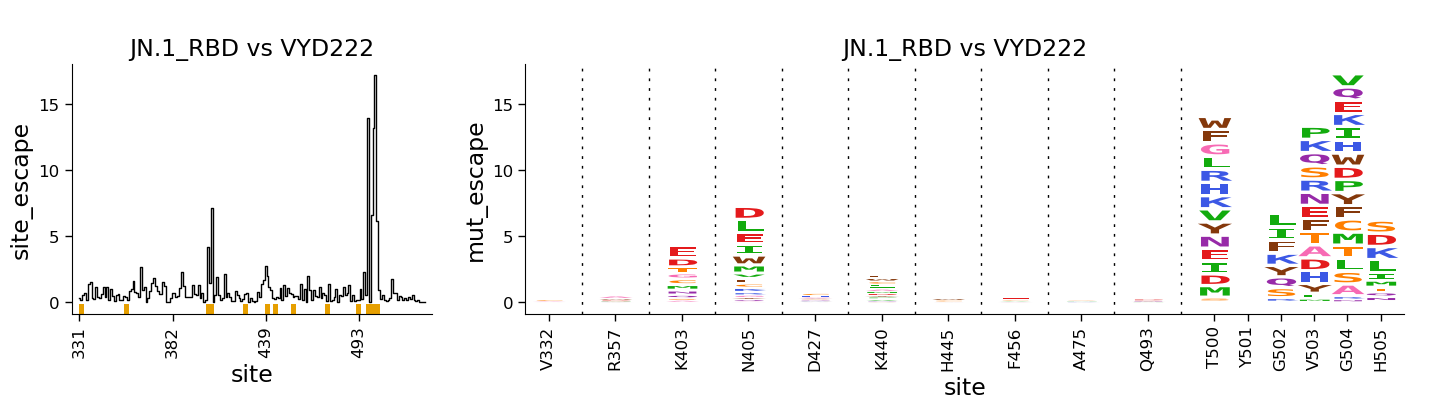

Saved VYD222_JN.1_RBD_line_logo_plot.svg
No data found for antibody='VYD222' vs antigen='XBB.1.5_RBD'


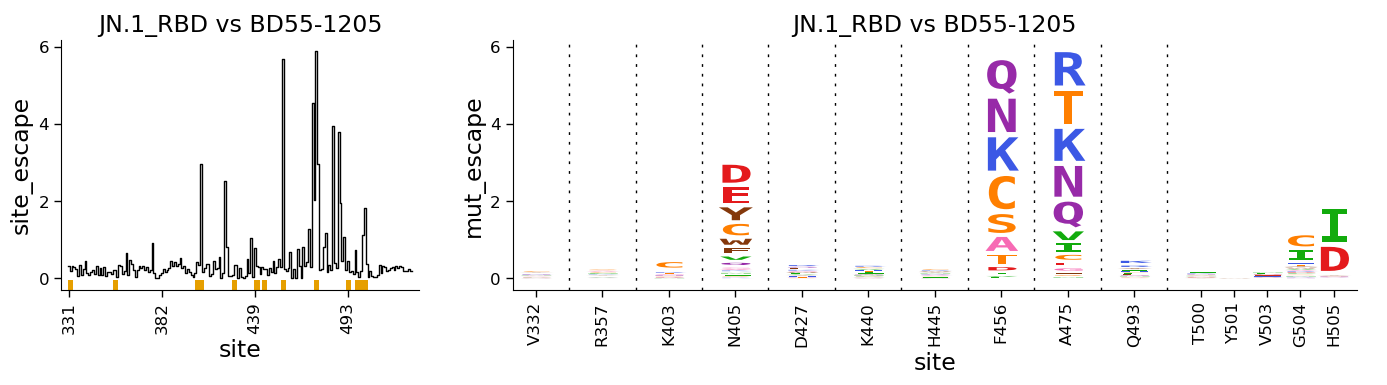

Saved BD55-1205_JN.1_RBD_line_logo_plot.svg


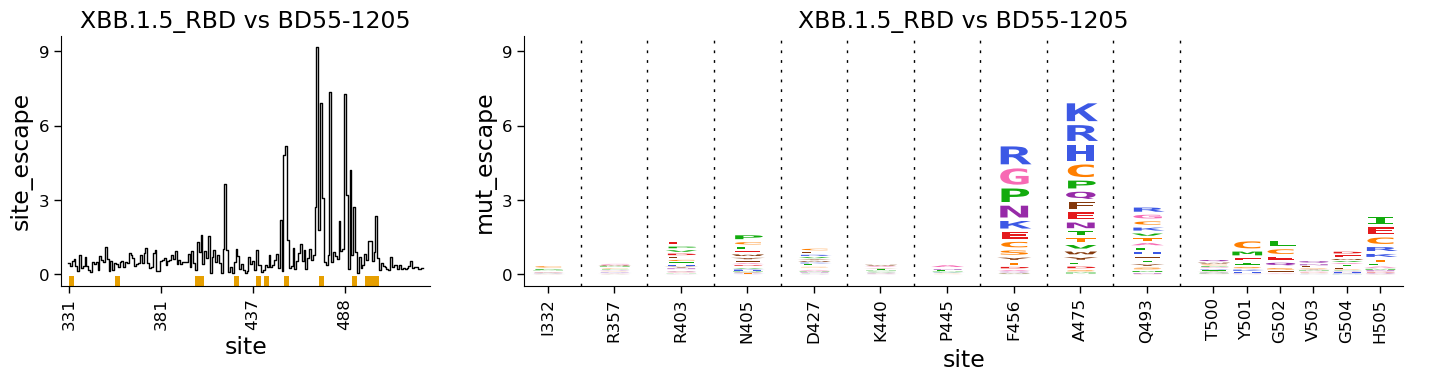

Saved BD55-1205_XBB.1.5_RBD_line_logo_plot.svg


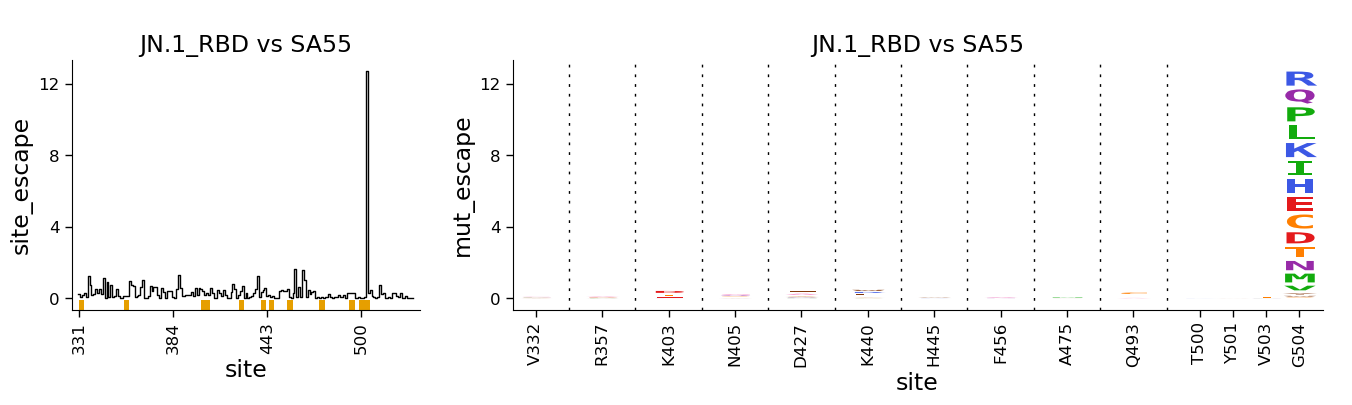

Saved SA55_JN.1_RBD_line_logo_plot.svg


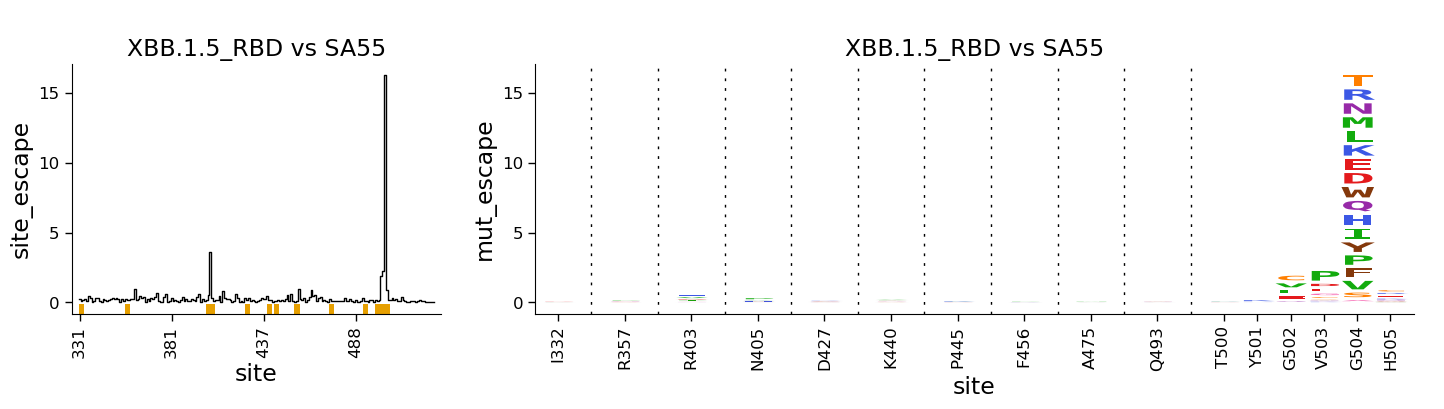

Saved SA55_XBB.1.5_RBD_line_logo_plot.svg


In [39]:
antibodies = set(df["antibody"])

antigens = sorted(df["antigen"].unique())

# antibodies to plot
antibodies_of_interest = ["VYD222", "BD55-1205", "SA55"]

for antibody, antigen in itertools.product(antibodies_of_interest, antigens):
    if (
        (antibody not in antibodies_of_interest)
        or (antigen not in set(df.query("antibody == @antibody")["antigen"]))
    ):
        print(f"No data found for {antibody=} vs {antigen=}")
        continue
        
    antibody_df = (
        df
        .query("antibody == @antibody")
        .query("antigen == @antigen")
        .assign(
            site_escape=lambda x: x.groupby(["site", "antigen"])["mut_escape"].transform("sum"),
            site_label=lambda x: x["wildtype"] + x["site"].astype(str),
        )
    )

    # add sequential sites
    antibody_df = antibody_df.merge(
        antibody_df[["site"]].drop_duplicates().reset_index(drop=True).reset_index(names="isite"),
        on="site",
        how="left"
    )
    
    # === Use existing show_site info from long_df ===
    matching_sites = (
        long_df
        .query("antibody == @antibody and show_site")
        ["site"]
        .unique()
        .tolist()
    )
    antibody_df["show_site"] = antibody_df["site"].isin(matching_sites)

    fig, axes = dmslogo.facet_plot(
        antibody_df,
        gridrow_col="antigen",
        x_col="isite",
        show_col="show_site",
        draw_line_kwargs={"height_col": "site_escape", "xtick_col": "site"},
        draw_logo_kwargs={
            "letter_col": "mutation",
            "letter_height_col": "mut_escape",
            "xtick_col": "site_label",
            "xlabel": "site",
        },
        share_ylim_across_rows=False,
        line_titlesuffix=f"vs {antibody}",
        logo_titlesuffix=f"vs {antibody}",
    )

    display(fig)
    svg_path = os.path.join("results/escape_logos", f"{antibody}_{antigen}_line_logo_plot.svg")
    fig.savefig(svg_path, format="svg", bbox_inches="tight")
    print(f"Saved {svg_path}")
    plt.close(fig)